# CNN Multiclass Classification



## Importing libraries

In [48]:
import os
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt

## Loading Dataset

### Dataset preprocessing and transformations

In [19]:
data_dir = 'data/images'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Before normalization and transforming to tensors, the range of each channel of RGB image is [0, 255].
# After converting to tensors using transforms.ToTensor(), the range of each channel of RGB image is [0, 1] (by dividing each pixel value by 255).
# transforms.Normalize() takes two parameters: mean (R,G,B) and std (R,G,B).
# Choice of 0.5 is commonly used and proved in several practical considerations in the context of training deep learning models.
# Mean of 0.5 for range [0, 1] in tensors results in shift of range to approximately [-1, 1] and for std too.

# Loading Dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Accessing dataset properties
print(f"Number of samples: {len(dataset)}")
print(f"Number of classes: {len(dataset.classes)}")
print(f"Class names: {dataset.classes}")

class_list = dataset.classes
class_to_idx = dataset.class_to_idx
print(f"Class to index: {class_to_idx}")


Number of samples: 30
Number of classes: 3
Class names: ['car', 'dog', 'person']
Class to index: {'car': 0, 'dog': 1, 'person': 2}


### Splitting dataset into training and validation sets

In [24]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

Training dataset size: 24
Test dataset size: 6


## Model definition: CNN

In [31]:
class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)  #Channel of 3 implicitly expects RGB image
        self.conv2 = nn.Conv2d(16,32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # (num_channels = 64, height = 28, width = 28)
        self.fc1 = nn.Linear(64*28*28, 128)
        self.fc2 = nn.Linear(128, 3) # 3 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64*28*28) # flattening the output of the last convolutional layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


Architecture Breakdown

```bash
Input Layer : 3 x 224 x 224

conv1 : 16 filters of size 3x3, stride 1, padding 1
Activation: ReLU
Output : 16 x 224 x 224
Max Pooling with kernel size 2x2, stride 2
Output : 16 x 112 x 112

conv2 : 32 filters of size 3x3, stride 1, padding 1
Activation: ReLU
Output : 32 x 112 x 112
Max Pooling with kernel size 2x2, stride 2
Output : 32 x 56 x 56

conv3 : 64 filters of size 3x3, stride 1, padding 1
Activation: ReLU
Output : 64 x 56 x 56
Max Pooling with kernel size 2x2, stride 2
Output : 64 x 28 x 28

Flatten Layer : feature map is flattened into a 1D vector (size: 64 * 28 * 28)

fc1 : 128 neurons
Activation: ReLU
Output : 128

fc2 : 3 neurons
Output : 3 logits 

torch.nn.CrossEntropyLoss : softmax activation applied to the output logits automatically. When we use CrossEntropyLoss, we should not apply Softmax in our model, as the loss function handles that.

```

In [32]:
# Calculating the height and width of the output of each layer

input_size = 224
Kernel_size = 2
Padding = 0
Stride = 2


output_size = ((input_size  - Kernel_size + 2 * Padding)/Stride) + 1

print(int(output_size))

112


## Defining training loop

In [35]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad() # zero the gradients of the model parameters
            outputs = model(images) # forward pass
            loss = criterion(outputs, labels) # calculate the loss
            loss.backward() # backpropagation
            optimizer.step() # optimize the model parameters
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')


## Initialise Loss function, model architecture and optimiser

In [59]:
model = DeepCNN()
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Model training

In [60]:
train_model(model, train_loader, criterion, optimizer, num_epochs=30)

Epoch [1/30], Loss: 1.4387
Epoch [2/30], Loss: 1.0389
Epoch [3/30], Loss: 0.9518
Epoch [4/30], Loss: 0.7355
Epoch [5/30], Loss: 0.4354
Epoch [6/30], Loss: 0.1713
Epoch [7/30], Loss: 0.1033
Epoch [8/30], Loss: 0.0634
Epoch [9/30], Loss: 0.0430
Epoch [10/30], Loss: 0.0595
Epoch [11/30], Loss: 0.0021
Epoch [12/30], Loss: 0.0005
Epoch [13/30], Loss: 0.0018
Epoch [14/30], Loss: 0.0014
Epoch [15/30], Loss: 0.0008
Epoch [16/30], Loss: 0.0005
Epoch [17/30], Loss: 0.0003
Epoch [18/30], Loss: 0.0003
Epoch [19/30], Loss: 0.0003
Epoch [20/30], Loss: 0.0003
Epoch [21/30], Loss: 0.0002
Epoch [22/30], Loss: 0.0002
Epoch [23/30], Loss: 0.0001
Epoch [24/30], Loss: 0.0001
Epoch [25/30], Loss: 0.0001
Epoch [26/30], Loss: 0.0001
Epoch [27/30], Loss: 0.0001
Epoch [28/30], Loss: 0.0001
Epoch [29/30], Loss: 0.0001
Epoch [30/30], Loss: 0.0000


## Model evaluation

In [61]:
def evaluate_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy of the model on the test images: {100 * correct / total:.2f}%')

In [62]:
# Evaluate the model
evaluate_model(model, test_loader)

# Save the model
torch.save(model.state_dict(), 'model.pth')

Accuracy of the model on the test images: 83.33%


In [63]:
def get_predictions(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    all_images = []
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_images.extend(images)
            all_labels.extend(labels)
            all_predictions.extend(predicted)
    
    return all_images, all_labels, all_predictions

In [64]:
images_pred, labels_pred, predictions_pred = get_predictions(model, test_loader)

In [65]:
def plot_predictions(images, labels, predictions, classes, num_images=12):
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(3, 4, i + 1)
        img = images[i].numpy().transpose((1, 2, 0))  # Convert to HxWxC format
        img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]
        
        # Map predicted class indices back to class names
        class_names = classes
        plt.imshow(img)
        plt.title(f'Label: {class_names[labels[i]]}\nPredicted: {class_names[predictions[i]]}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

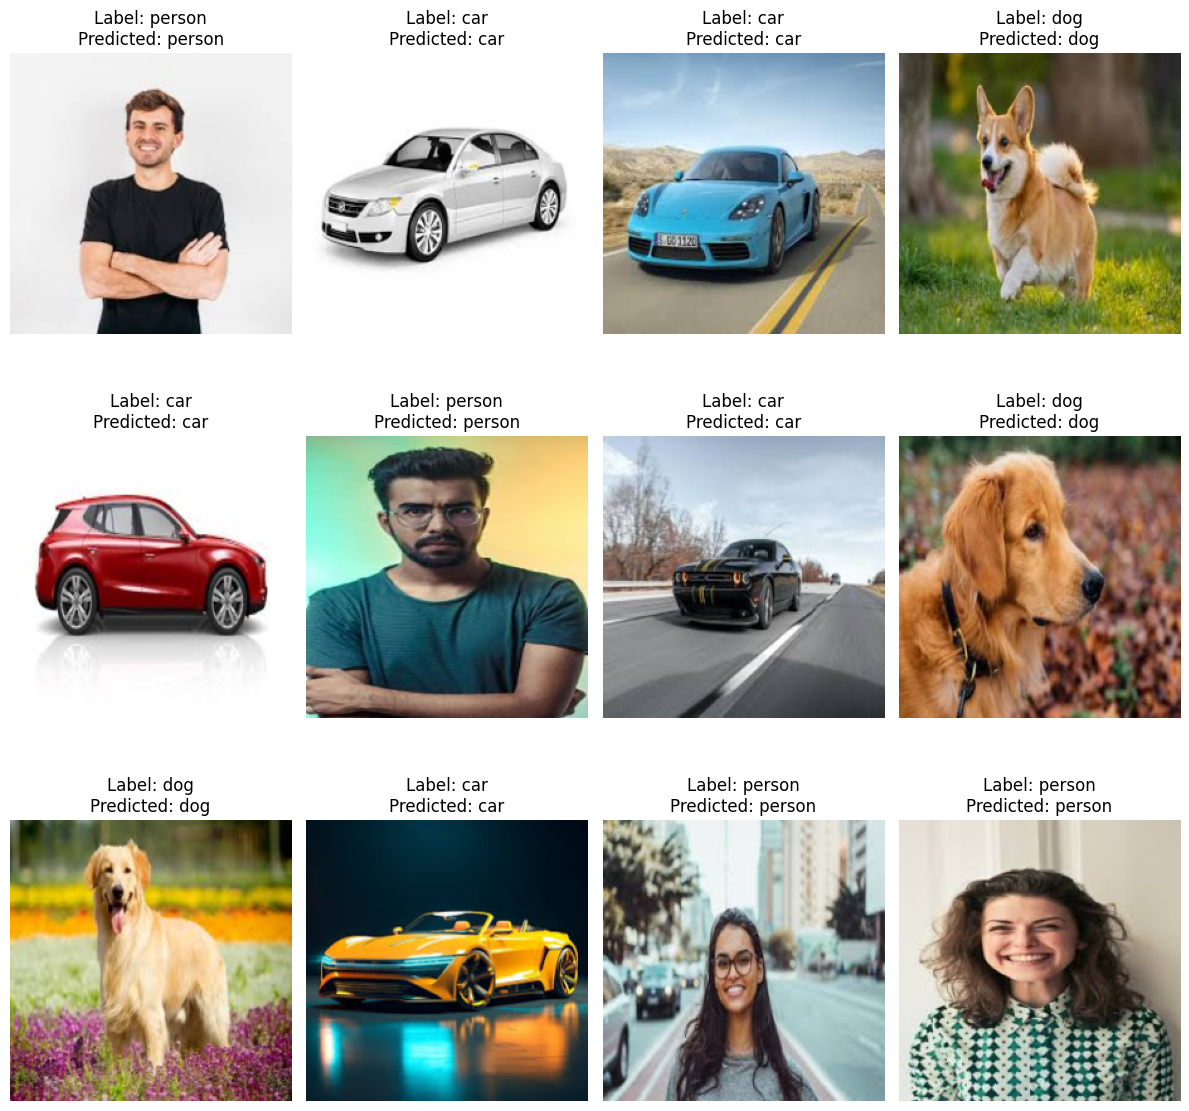

In [66]:
images_train, labels_train, predictions_train = get_predictions(model, train_loader)
num_images = min(12, len(images_train))
plot_predictions(images_train, labels_train, predictions_train, classes=class_list, num_images=num_images)

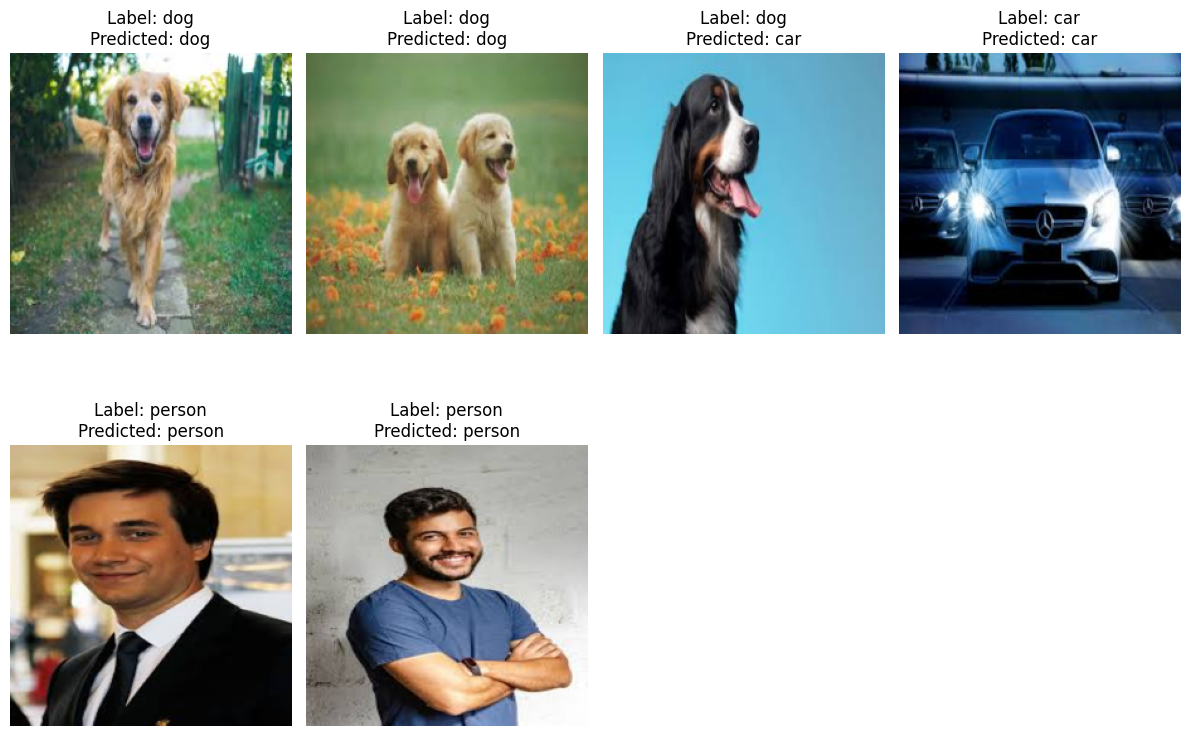

In [67]:
num_images = min(12, len(images_pred))
plot_predictions(images_pred, labels_pred, predictions_pred, classes=class_list, num_images=num_images)